Dask Approach to Non-SQL PTM Queries
--

* v01: move away from classes, try to organize the computation 
primarily in dask.
* v02: target optimization.
* v03: why not Bayesian?
* emcee_v01: refine Bayesian to use a counting distribution

The observations are overdisperse, and a Poisson distribution did not
lead to convergence. A negative binomial was much better, with a dispersion
parameter $\alpha \approx 1.75$ performed well, with $\alpha$ determined
*a priori* by MLE. This was done in three steps:
1. Fit a negative binomial to the full set of observations, not conditioned
   on the model output. Though dependent on the handling of blank contamination,
   this yields $\alpha \approx 3.4$. Q-Q plots show that log-normal is very good
   when ignoring blank contamination, but negative binomial is better when 
   blank contamination is subtracted out. I did not re-attempt this process
   with the updated marginal likelihood code.
2. Fit model rates (decay, beaching, deposition) based on that $\alpha$, by
   maximum likelihood.
3. Use the result of 2 as a starting point to fit rates *and* $\alpha$, again
   use maximum likelihood.  This yields $\alpha \approx 1.73$.

The updated $\alpha$ was then kept constant for the MCMC sampling. The result
was

Accounting for blank contamination
--
When fitting a distribution to the overall set of observations, I originally
ignored blank contamination, and log-normal was the clear winner. Offsetting
the observations by a constant to account for blank contamination makes 
negative binomial closer, and log-normal becomes worse. This is in part because
we end up with some zero-inflation, those have to be clipped to >0 for log-normal,
and the fit deteriorates.

This leads to the question of how to properly implement the likelihood. I think 
what I want to say is:
$$
\begin{align}
 N_{i,true}  & \sim \textrm{NegBinom}( \mu=N_{i,model}, \alpha=\alpha_0 ) \\
 N_{i,blank} & \sim \textrm{Poisson}( \mu=\mu_{blank} ) \\
 N_{i,obs}   & = N_{i,true} + N_{i,blank}
\end{align}
$$

Attempting to parrot some notation from [https://krasserm.github.io/2019/11/21/latent-variable-models-part-1/](here)

$\mathbf{\theta}$ are my model parameters. In my case, 
$\mathbf{\theta} = \{k_{beach},k_{deposit},k_{decay}\}$.

The hydrodynamics, particle tracking, and source loading collectively define a forward model
$$
\mu_i = M(obs_i,\theta)
$$
where $i$ indexes observations, $\mu_i$ is the count predicted by the model, $obs_i$ encapsulates the observation metadata (time, location, trawl area).

Take $x_i$ to be the observed count. The first set of equations above can be rewritten in this likelihood form
as
$$
p(x_i|b_i,\theta) = \textrm{NB}\left(x_i-b_i | \mu_i,\alpha \right)
$$
where $b_i$ is the blank contamination for observation $i$. This is fine if we intend
to sample $b_i$. Based on the measurements of blank contamination, we have a
reasonable prior for $b_i$ as a sum of 5 Poisson distributions. 

But instead of sampling $b_i$, I want to marginalize it
$$
p(x_i|\theta) = \sum_{b_i\in \textit{N}} p(b_i) p(x_i|b_i,\theta)
$$

***I've lost my way.***




*Without* the blank issue, I have:
$$
LL_i = \textrm{NegBinom.logpmf}( N_{i,obs}, \mu=N_{i,model}, \alpha=\alpha_0)
$$
or in other words, use the negative binomial distribution with a mean predicted
by the model and evaluate it for the observed count.

I think that one option to include blanks is to explicitly integrate over the Poisson:
$$
LL_i = \log \left[ \sum_{b=b_{min}}^{b_{max}} 
                     \textrm{NegBinom.pmf}( N_{i,obs}-b, \mu=N_{i,model}, \alpha=\alpha_0)
                     \cdot
                     \textrm{Poisson.pmf}( b, \mu_{blank} ) 
           \right]
$$

The mean contamination is on the order of 4, so this integration could test for $b\in[0,15]$
and capture enough of the probability mass.

Accounting for catch efficiency
--
Simply including a global scale factor leads to confusion. The optimization
and mcmc sampling try to increase both the scale factor and the beaching rate.
Seems to be specific to beaching and scale. Deposition and decay are still 
distributed near 0. MAP puts beaching at 0.497 and scale at 2.1006. If instead
I set scale at 0.5, what beaching comes out? 0.10445.

Basic comparison of scatter plots for these two parameter sets is not illuminating.
Visually the scale=2, beaching=0.5 parameters do look a tiny bit cleaner.


What does this mean?
 * Current beaching approach is not sensitive enough.
 * Data are insufficient to fit both scale and beaching.

What to do?
 * Break samples out into morphologies, size groups, settling velocity classes. 
 * Set catch efficiency from literature?


Suggestions from Ed:
- Negative binomial or actually multinomial (to get, e.g., a size distribution)
- probably have to use a discrete distribution
- Laura Mitchell paper about how to deal with catchability of fish.

In [2]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

import itertools

import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re
from scipy.optimize import minimize
from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

In [3]:
import six

# Experiment level configuration -- small, all python native data.
import cfg_v01 
six.moves.reload_module(cfg_v01)
cfg=cfg_v01.cfg # note that changes to this will not be visible to subprocesses

import postproc_mp as post
six.moves.reload_module(post)

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<module 'postproc_mp' from '/home/rusty/src/microplastic_sfbay/postprocess/postproc_mp.py'>

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [4]:
# This doesn't seem to work from within jupyter notebook.
# it allocates huge amounts of memory and gets stuck.
# import multiprocessing
compute_kw={} # dict(pool=multiprocessing.Pool(24))

In [5]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=cfg.grid.smooth_matrix()
Msmooth_K=cfg.grid.smooth_matrix(K=100*np.ones(cfg.grid.Nedges()))

INFO:utils:73727/99089
INFO:utils:73274/99089


In [6]:
areas=cfg.grid.cells_area()    

In [7]:
# Set this a bit early, as it controls cache location which 
# is needed for some testing.

# now the 021b runs.
# c suffix: use tighter -0.095 z filter.
# 20200227: start of v03
# 20200302: start of v04
# 20200305: try larger window -- extra 24 hours in both directions.
# 20200312: new sources in ptm data, with v02 stormwater concs.
# 20200330: more new sources.
# 20210210a: dask code, new hydro, new ptm. new year.
# 20210317a: new ptm runs with no SJ loss...
#            has the w_s bug
# 20210317b: fixed w_s bug
# 20210317c: switch to weathered loads
# 20210708c: including beaching and deposition counts.
# 20210726d: other stuff, and now prep to optimize just 3 parameters
# 20211001:  355um loads

os.makedirs(cfg['manta_out_dir'],exist_ok=True)

In [8]:
import postproc_dask
six.moves.reload_module(postproc_dask)
six.moves.reload_module(cfg_v01)
cfg=cfg_v01.cfg
six.moves.reload_module(post)

<module 'postproc_mp' from '/home/rusty/src/microplastic_sfbay/postprocess/postproc_mp.py'>

Using `postproc_mp`
--

Verified that particle results are identical. Wastewater includes the
adjustment to new, 355-um only, loads. Stormwater this is difficult, and
while the distribution reflects the 355-um data, that counts reflect the
land-use model. Will use storm_factor=0.326 below to deal with this.

In [9]:
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
# manta.head()

In [10]:
blank_rates=pd.read_csv("blank_rates-v04.csv").set_index('cat')['blank_rate']

In [11]:
blank_rates

cat
Fiber           42.000
Fiber Bundle     1.875
Fragment         1.875
Foam             0.125
Film             0.000
Sphere           0.000
Name: blank_rate, dtype: float64

In [12]:
godwin_offset_h=post.godwin_offset_h
godwin=post.godwin

In [13]:
import numexpr as ne
ne.set_num_threads(16) # reasonable on cws-linuxmodeling

8

In [14]:
# Streamlined version that only allows 
# tau, shore_factor and bed_factor to change.
# Msmooth is already set.

# Precalculate:
if 1: 
    manta_chrono=manta.sort_values('DATE') # helps with locality during precalculation
    # I think this is the deal -- it's not practical to calculate 
    # the stormwater loads using only 355um samples (would require re-implementing
    # watershed fitting, among other issues)
    # so instead use the overall stormwater load reduction here
    storm_factor=0.326
    step=-10000
    precalc={} # idx => stuff.

    # Force mantas to be sorted, so that data from the same day
    # is grouped together.
    last_DATE=None
    df=None

    for idx,rec in utils.progress(manta_chrono.iterrows()):
        #print(idx)
        # since we're just pulling out whole days, cache by day.
        # and pull through the end of that day
        # 5s, all in read_parquet
        if rec.DATE==last_DATE:
            pass
        else:
            df=post.particles_for_date(rec.DATE,cfg=cfg,compute_kw=compute_kw)
            last_DATE=rec.DATE

        # Trawl-specific processing:
        # Pull subset of cells
        # add a cell weighting, and a time weighting for the tidal filter
        cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=cfg.grid,
                                               Msmooth=Msmooth,smooth=step,thresh=1e-5)
        df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
        df_spatial_sort=df_spatial.sort_index()
        space_cell=df_spatial_sort.index.values
        space_weight=df_spatial_sort['weight_spatial'].values
        df_cell=df.cell.values
        df_idx=np.searchsorted(space_cell,df_cell).clip(0,len(space_cell)-1)
        sel=space_cell[df_idx]==df_cell
        tdf=df[sel].copy()
        weight_spatial=space_weight[df_idx[sel]]

        #t_sample=np.datetime64(rec['DATE'])    
        #t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
        #delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
        #weight_time=godwin[delta_hours+godwin_offset_h]
        weight_time=tdf['weight_time'].values
        
        age=tdf['time'].values - tdf['rel_time'].values

        age_s=(age/np.timedelta64(1,'s')).astype(np.float32)
        bed_hits=tdf['bed_hits'].values
        shore_hits=tdf['shore_hits'].values
        mp_per_area = (tdf['mp_per_particle'] / areas[tdf['cell']]).values

        group_weight=post.group_weights(tdf,storm_factor)

        # Omits decay, bed, shore weights
        pre_weighted=weight_spatial*weight_time*group_weight*mp_per_area
        # Final code below then needs age_s, bed_hits, shore_hits
        sel=pre_weighted>0.0
        
        bundle=np.zeros(sel.sum(),[('preweighted',np.float32),
                                   ('age_s',np.float32),
                                   ('bed_hits',np.int16),
                                   ('shore_hits',np.int16)])
        bundle['preweighted']=pre_weighted[sel]
        bundle['age_s']=age_s[sel]
        bundle['bed_hits']=bed_hits[sel]
        bundle['shore_hits']=shore_hits[sel]
        
        print(f"Manta sample {idx}: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        # Can get maybe a factor of 3 by combining duplicates
        df_bundle=pd.DataFrame.from_records(bundle)
        uniquified=df_bundle.groupby(['age_s','bed_hits','shore_hits'])['preweighted'].sum().reset_index()
        bundle=np.zeros(len(uniquified),dtype=bundle.dtype)
        bundle['preweighted']=uniquified['preweighted']
        bundle['age_s']=uniquified['age_s']
        bundle['bed_hits']=uniquified['bed_hits']
        bundle['shore_hits']=uniquified['shore_hits']
        print(f"    uniquified: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        precalc[idx]=bundle

#                        weights=ne.evaluate('weight_spatial*weight_time*decay*group_weight*bed_weight*shore_weight')
#                        unweighted=mp_per_area
#                        final_weights=weights
#                        # final_concs=weights*mp_per_area
#                        C=ne.evaluate( 'sum(weights*mp_per_area)')

Reading from cache
done
Manta sample 0: 4.37e+08 bytes, 3.64e+07 elements


INFO:utils:1


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 1: 4.38e+08 bytes, 3.65e+07 elements


INFO:utils:2


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Manta sample 2: 4.25e+08 bytes, 3.54e+07 elements


INFO:utils:3


    uniquified: 1.40e+08 bytes, 1.17e+07 elements
Manta sample 3: 4.38e+08 bytes, 3.65e+07 elements


INFO:utils:4


    uniquified: 1.44e+08 bytes, 1.20e+07 elements
Reading from cache
done
Manta sample 4: 4.06e+08 bytes, 3.38e+07 elements


INFO:utils:5


    uniquified: 1.38e+08 bytes, 1.15e+07 elements
Manta sample 5: 4.30e+08 bytes, 3.59e+07 elements


INFO:utils:6


    uniquified: 1.43e+08 bytes, 1.19e+07 elements
Manta sample 6: 4.27e+08 bytes, 3.56e+07 elements


INFO:utils:7


    uniquified: 1.42e+08 bytes, 1.19e+07 elements
Manta sample 7: 4.32e+08 bytes, 3.60e+07 elements


INFO:utils:8


    uniquified: 1.43e+08 bytes, 1.19e+07 elements
Reading from cache
done
Manta sample 11: 3.53e+08 bytes, 2.94e+07 elements


INFO:utils:9


    uniquified: 1.29e+08 bytes, 1.07e+07 elements
Manta sample 10: 3.52e+08 bytes, 2.93e+07 elements


INFO:utils:10


    uniquified: 1.28e+08 bytes, 1.06e+07 elements
Manta sample 8: 3.49e+08 bytes, 2.91e+07 elements


INFO:utils:11


    uniquified: 1.27e+08 bytes, 1.06e+07 elements
Manta sample 9: 3.33e+08 bytes, 2.78e+07 elements


INFO:utils:12


    uniquified: 1.22e+08 bytes, 1.02e+07 elements
Reading from cache
done
Manta sample 12: 2.95e+08 bytes, 2.45e+07 elements


INFO:utils:13


    uniquified: 1.14e+08 bytes, 9.48e+06 elements
Manta sample 13: 3.04e+08 bytes, 2.53e+07 elements


INFO:utils:14


    uniquified: 1.16e+08 bytes, 9.64e+06 elements
Manta sample 14: 2.21e+08 bytes, 1.84e+07 elements


INFO:utils:15


    uniquified: 9.15e+07 bytes, 7.62e+06 elements
Reading from cache
done
Manta sample 15: 4.12e+08 bytes, 3.44e+07 elements


INFO:utils:16


    uniquified: 1.42e+08 bytes, 1.18e+07 elements
Manta sample 16: 4.12e+08 bytes, 3.44e+07 elements


INFO:utils:17


    uniquified: 1.42e+08 bytes, 1.18e+07 elements
Reading from cache
done
Manta sample 17: 4.65e+08 bytes, 3.88e+07 elements


INFO:utils:18


    uniquified: 1.39e+08 bytes, 1.16e+07 elements
Reading from cache
done
Manta sample 18: 4.38e+08 bytes, 3.65e+07 elements


INFO:utils:19


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 19: 4.37e+08 bytes, 3.64e+07 elements


INFO:utils:20


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 20: 4.38e+08 bytes, 3.65e+07 elements


INFO:utils:21


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 21: 4.37e+08 bytes, 3.64e+07 elements


INFO:utils:22


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Reading from cache
done
Manta sample 22: 3.74e+08 bytes, 3.12e+07 elements


INFO:utils:23


    uniquified: 1.22e+08 bytes, 1.02e+07 elements
Manta sample 23: 3.79e+08 bytes, 3.16e+07 elements


INFO:utils:24


    uniquified: 1.23e+08 bytes, 1.03e+07 elements
Manta sample 24: 4.09e+08 bytes, 3.41e+07 elements


INFO:utils:25


    uniquified: 1.31e+08 bytes, 1.09e+07 elements
Manta sample 25: 4.68e+08 bytes, 3.90e+07 elements


INFO:utils:26


    uniquified: 1.47e+08 bytes, 1.22e+07 elements
Reading from cache
done
Manta sample 26: 3.17e+08 bytes, 2.64e+07 elements


INFO:utils:27


    uniquified: 1.23e+08 bytes, 1.02e+07 elements
Reading from cache
done
Manta sample 27: 5.58e+08 bytes, 4.65e+07 elements


INFO:utils:28


    uniquified: 1.57e+08 bytes, 1.31e+07 elements
Manta sample 28: 5.00e+08 bytes, 4.17e+07 elements


INFO:utils:29


    uniquified: 1.40e+08 bytes, 1.17e+07 elements
Manta sample 29: 4.91e+08 bytes, 4.10e+07 elements


INFO:utils:30


    uniquified: 1.39e+08 bytes, 1.16e+07 elements
Reading from cache
done
Manta sample 30: 3.04e+08 bytes, 2.53e+07 elements


INFO:utils:31


    uniquified: 8.75e+07 bytes, 7.30e+06 elements
Manta sample 31: 3.04e+08 bytes, 2.53e+07 elements


INFO:utils:32


    uniquified: 8.75e+07 bytes, 7.29e+06 elements
Reading from cache
done
Manta sample 37: 6.18e+08 bytes, 5.15e+07 elements


INFO:utils:33


    uniquified: 1.30e+08 bytes, 1.09e+07 elements
Manta sample 36: 6.18e+08 bytes, 5.15e+07 elements


INFO:utils:34


    uniquified: 1.30e+08 bytes, 1.09e+07 elements
Manta sample 35: 6.18e+08 bytes, 5.15e+07 elements


INFO:utils:35


    uniquified: 1.30e+08 bytes, 1.09e+07 elements
Manta sample 32: 6.23e+08 bytes, 5.19e+07 elements


INFO:utils:36


    uniquified: 1.32e+08 bytes, 1.10e+07 elements
Manta sample 33: 6.24e+08 bytes, 5.20e+07 elements


INFO:utils:37


    uniquified: 1.33e+08 bytes, 1.11e+07 elements
Manta sample 34: 6.18e+08 bytes, 5.15e+07 elements


INFO:utils:38


    uniquified: 1.30e+08 bytes, 1.09e+07 elements
Reading from cache
done
Manta sample 38: 5.09e+08 bytes, 4.24e+07 elements


INFO:utils:39


    uniquified: 1.18e+08 bytes, 9.81e+06 elements
Manta sample 39: 4.93e+08 bytes, 4.11e+07 elements


INFO:utils:40


    uniquified: 1.14e+08 bytes, 9.51e+06 elements
Manta sample 40: 5.04e+08 bytes, 4.20e+07 elements


INFO:utils:41


    uniquified: 1.16e+08 bytes, 9.69e+06 elements
Reading from cache
done
Manta sample 41: 3.01e+08 bytes, 2.51e+07 elements


INFO:utils:42


    uniquified: 7.48e+07 bytes, 6.24e+06 elements
Manta sample 42: 2.97e+08 bytes, 2.48e+07 elements


INFO:utils:43


    uniquified: 7.45e+07 bytes, 6.21e+06 elements
Manta sample 43: 3.02e+08 bytes, 2.52e+07 elements


INFO:utils:44


    uniquified: 7.51e+07 bytes, 6.26e+06 elements
Reading from cache
done
Manta sample 52: 2.17e+08 bytes, 1.81e+07 elements


INFO:utils:45


    uniquified: 5.61e+07 bytes, 4.67e+06 elements
Manta sample 51: 2.16e+08 bytes, 1.80e+07 elements


INFO:utils:46


    uniquified: 5.60e+07 bytes, 4.67e+06 elements
Manta sample 49: 1.57e+08 bytes, 1.31e+07 elements


INFO:utils:47


    uniquified: 4.56e+07 bytes, 3.80e+06 elements
Manta sample 50: 2.14e+08 bytes, 1.79e+07 elements


INFO:utils:48


    uniquified: 5.57e+07 bytes, 4.64e+06 elements
Reading from cache
done
Manta sample 48: 4.74e+08 bytes, 3.95e+07 elements


INFO:utils:49


    uniquified: 1.04e+08 bytes, 8.67e+06 elements
Manta sample 46: 4.73e+08 bytes, 3.94e+07 elements


INFO:utils:50


    uniquified: 1.04e+08 bytes, 8.64e+06 elements
Manta sample 45: 4.64e+08 bytes, 3.87e+07 elements


INFO:utils:51


    uniquified: 1.03e+08 bytes, 8.56e+06 elements
Manta sample 44: 4.63e+08 bytes, 3.86e+07 elements


INFO:utils:52


    uniquified: 1.03e+08 bytes, 8.55e+06 elements
Manta sample 47: 4.73e+08 bytes, 3.95e+07 elements


INFO:utils:53


    uniquified: 1.04e+08 bytes, 8.65e+06 elements
Reading from cache
done
Manta sample 55: 2.67e+08 bytes, 2.23e+07 elements


INFO:utils:54


    uniquified: 8.04e+07 bytes, 6.70e+06 elements
Manta sample 56: 2.70e+08 bytes, 2.25e+07 elements


INFO:utils:55


    uniquified: 8.10e+07 bytes, 6.75e+06 elements
Manta sample 53: 2.80e+08 bytes, 2.33e+07 elements


INFO:utils:56


    uniquified: 8.33e+07 bytes, 6.95e+06 elements
Manta sample 54: 2.73e+08 bytes, 2.27e+07 elements


INFO:utils:57


    uniquified: 8.18e+07 bytes, 6.82e+06 elements
Reading from cache
done
Manta sample 57: 2.70e+08 bytes, 2.25e+07 elements


INFO:utils:58


    uniquified: 8.19e+07 bytes, 6.82e+06 elements
Manta sample 58: 2.59e+08 bytes, 2.16e+07 elements


INFO:utils:59


    uniquified: 7.94e+07 bytes, 6.62e+06 elements
Manta sample 59: 2.86e+08 bytes, 2.38e+07 elements


INFO:utils:60


    uniquified: 8.43e+07 bytes, 7.03e+06 elements
Manta sample 60: 3.13e+08 bytes, 2.61e+07 elements


INFO:utils:61


    uniquified: 9.18e+07 bytes, 7.65e+06 elements
Manta sample 61: 3.13e+08 bytes, 2.61e+07 elements


INFO:utils:62


    uniquified: 9.18e+07 bytes, 7.65e+06 elements
Reading from cache
done
Manta sample 63: 2.33e+08 bytes, 1.94e+07 elements


INFO:utils:63


    uniquified: 7.56e+07 bytes, 6.30e+06 elements
Manta sample 62: 2.27e+08 bytes, 1.89e+07 elements


INFO:utils:64


    uniquified: 7.44e+07 bytes, 6.20e+06 elements
Manta sample 64: 2.57e+08 bytes, 2.14e+07 elements
    uniquified: 8.06e+07 bytes, 6.72e+06 elements


In [ ]:
%load_ext line_profiler

In [18]:
pred_type=np.float64

def predict_mantas_fast(decay_rate,beach_rate=1e-2,depo_rate=1e-2):
    # tau_d: e-folding decay time scale in days
    # shore_factors: particle weight derated by (1-shore_factor)**hits
    # bed_factors: particle weighte derated by (1-bed_factor)**hits
    # print(f"tau={decay_rate}  shore={beach_rate}  bed={depo_rate}")
    preds=[]

    for idx,rec in utils.progress(manta_chrono.iterrows()):
        # print(idx)
        bundle=precalc[idx]
        age_s=bundle['age_s']
        shore_hits=bundle['shore_hits']
        bed_hits=bundle['bed_hits']
        preweighted=bundle['preweighted']
                                        
        pred=dict(idx=idx,storm_factor=storm_factor,decay_rate=decay_rate,
                  step=step,Msmooth_i=0,
                  beach_rate=beach_rate,depo_rate=depo_rate)
        pred['idx']=idx
    
        # All in one go was actually half as fast
        weight=ne.evaluate('''exp( -age_s*decay_rate/86400. 
                                   -shore_hits*beach_rate 
                                   -bed_hits*depo_rate )''')
        C=ne.evaluate( 'sum(preweighted*weight)')
         
        pred['C_model']=C
        preds.append(pred)

    df_pred=pd.DataFrame(preds)
    df_pred['C_model']=df_pred['C_model'].astype(np.float64)
    manta_pred=df_pred.join(manta_chrono,on='idx')
    return manta_pred

def predict_mantas_fast_multi(tau_ds,shore_factors,bed_factors):
    dfs=[]
    for tau_d,shore_factor,bed_factor in itertools.product(tau_ds,shore_factors,bed_factors):
        #print(f"tau={tau/np.timedelta64(86400,'s')}d shore_factor={shore_factor}  bed_factor={bed_factor}")
        dfs.append(predict_mantas_fast(tau_d,shore_factor=shore_factor,bed_factor=bed_factor))
    combined=pd.concat(dfs)
    return combined
            

In [19]:
%%time
# 6.7s
# 2.8s after combining all rates, which regresses to 5.5s if I do the
# summation in line, too.
# Those times with 8 threads. Down to 1.9s with 16 threads.
# Back to 2.49 if 64 bit. 
#%lprun -f predict_mantas_fast 
result=predict_mantas_fast(decay_rate=0.01,beach_rate=0.2,depo_rate=0.001)
#metrics(result)

CPU times: user 15.9 s, sys: 2.72 s, total: 18.6 s
Wall time: 2.62 s


Counting Distributions
--

The existing columns in manta below.

The ones of interest are
- area_m2
- count_preblank_nofiber
- count_nofiber
- part_per_m2_nofiber
- part_per_m2_raw_nofiber

Currently I make adjustments to the observations,
1. estimate contamination for each of the morphologies
2. adjust counts for contamination, sum over morphology
3. Normalize by sample area.

This value is compared directly to the model output.

Currently using manta_summary-v03.csv, produced by `adjust_manta_sediment.py`



Predicting counts from the model:
- "True" mean count for sample is $N_{true} =C_{model} \cdot A_{sample} $. Area is in m2, C_model is in particles per square meter.
- Observations are then $$\textrm{count_preblank} \sim 
 Poisson(N_{true}) + Poisson(N_{film}) + Poisson(N_{sphere}) + \cdots$$

```
SampleID
SAMPLE LOCATION
DATE
TYPE
LAT START
LONG START
LAT END
LONG END
TOTAL DIST (M)
START FLOW
END FLOW
area_km2
volume_m3
FibersYN
Season
time_local
time_utc
lat
lon
volume_l
area_m2
count_preblank_std
count_preblank_nofiber
Fiber
Fiber Bundle
Film
Foam
Fragment
Sphere
Fiber_adj
Fiber Bundle_adj
Fragment_adj
Foam_adj
Film_adj
Sphere_adj
count_std
count_nofiber
part_per_m3_std
part_per_m2_std
part_per_m3_raw_std
part_per_m2_raw_std
part_per_m3_nofiber
part_per_m2_nofiber
part_per_m3_raw_nofiber
part_per_m2_raw_nofiber
x
y
```

Optimization
==

Before something more sophisticated like stan or max likelihood, 
just optimize a cost function.

1. Maximize r_log.  This worked well, giving tau=90.47 shore=0.037 and bed=-0.0075. Even without any constraints, the values are not too crazy, and the result a bit better than before, $r_{log} = 0.7214559$. But I'm having trouble getting this result after changing the code to use 64-bit floats, so maybe that was a fluke.
2. Constrained optimization did not move much at all from the initial. This may be due to estimating gradients with a smaller epsilon than fmin, in fact slightly smaller than a 32-bit float can represent. The form is so simple that we might as well calculated gradients.
3. That said, unconstrained optimization with a penalty did not do any better. 

In [20]:
# ensure that observed values are positive.
obs=manta_chrono['part_per_m2_nofiber'].values
detect_limit=0.5*obs[obs>0].min()
observed=obs.clip(detect_limit)

In [21]:
from scipy import stats
import emcee

In [22]:
cats=['Fiber Bundle','Fragment','Foam', 'Film','Sphere']

<IPython.core.display.Javascript object>


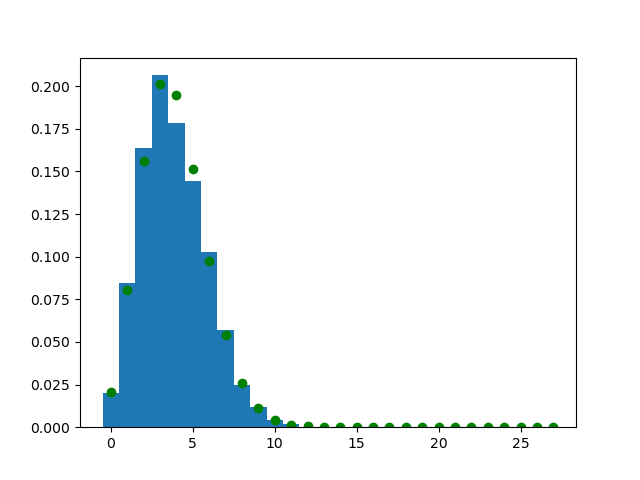

In [23]:
# Precalculate distribution for blanks
from functools import reduce

samps=np.arange(10)
dists=[stats.poisson.pmf(samps,blank_rates[cat]) for cat in cats]

blank_sum_dist=reduce(np.convolve,dists)
# Trim trailing zeros
last_nonzero=np.nonzero(blank_sum_dist)[0][-1]
blank_sum_dist=blank_sum_dist[:last_nonzero+1]

if 1: # "verify" distribution against sampling
    # First, the "empirical" distribution
    blanks=[np.sum( [stats.poisson.rvs(blank_rates[cat]) for cat in cats])
            for _ in range(5000)]
    plt.figure()
    # Very close. Not sure why the peak is slightly shifted.
    plt.hist(blanks,density=True,bins=np.arange(25)-0.5)
    plt.plot(blank_sum_dist,'go')

In [375]:
# The real setup
from scipy.special import logsumexp

def log_prior(theta):
    beach_rate,depo_rate,decay_rate=theta
    if beach_rate<0 or depo_rate<0 or decay_rate<0:
        return -np.inf
    return 0  # flat prior for non-negative values

# theta is parameter vector.
ncalls=0
def log_likelihood(theta,alpha,scale=1.0):
    global ncalls
    ncalls+=1
    LL=0.0
    beach_rate,depo_rate,decay_rate=theta

    df=predict_mantas_fast(decay_rate=decay_rate,
                           beach_rate=beach_rate,
                           depo_rate=depo_rate)

    sigma=1.0 # log units
    LL=0
    
    for idx,rec in df.iterrows():
        o=rec['count_preblank_nofiber']
        m=scale * rec['C_model'] * rec['area_m2']
        # ? o=max(o,detect_limit)
        
        if np.isinf(m):
            print("Model result was nan for ",theta)
            return -np.inf
        # Previous way:
        #ll = stats.norm.logpdf( np.log(o), np.log(m), sigma ) 
        
        # o ~ m + Pois(blank_rates['Fiber Bundle'])
        #       + Pois(blank_rates['Fragment'])
        #       + Pois(blank_rates['Foam'])
        #       + Pois(blank_rates['Film'])
        #       + Pois(blank_rates['Sphere']) 
        # Poisson is terrible here
        # ll = stats.poisson.logpmf(o, m+blanks)
        # alpha=3.37 # fit below
        # convert to the parameters scipy wants
        mu=m
        sigma2=mu+alpha*mu**2
        p=mu/sigma2 
        n=1/alpha 
        if 0: # sampling approach to deal with blanks
            # This is going to be -inf sometimes!!
            # And chances are one of the samples will end up nan
            # The clip here is not quite right I think
            blanks=np.sum( [stats.poisson.rvs(blank_rates[cat]) for cat in cats])
            ll = stats.nbinom.logpmf( (o-blanks).clip(0) ,n,p)
        if 1: # integration approach for blanks
            lls=[]
            for nblank,pm in enumerate(blank_sum_dist):
                if (pm>0.0) and (o-nblank)>=0:
                    lls.append( np.log(pm) + stats.nbinom.logpmf(o-nblank,n,p))
                else:
                    pass # probability=0
            ll=logsumexp(lls)

        # print(f"obs: {o}  mod: {m}  blanks: {blanks}   log PMF: {ll}")        
        LL+=ll
    return LL

# Original alpha=3.37 came from fitting NegativeBinomial to the full set of
# observations with some nominal blank subtraction.
# After finding some decent parameters with that alpha, a second optimization
# step (starting from the result of the first), additionally tuned alpha and
# finds alpha=1.75. So that's now the default here.
if 1:
    def log_posterior(theta,alpha=1.75,scale=1.0):
        l=log_prior(theta)
        if np.isfinite(l):
            l += log_likelihood(theta,alpha=alpha,scale=scale)
        return l
    dims=['beach','depo','decay']
if 0:
    def log_posterior(theta,alpha=1.75):
        scale=theta[-1]
        theta=theta[:-1]
        l=log_prior(theta)
        if scale<0.01:
            return -np.inf
        if np.isfinite(l):
            l += log_likelihood(theta,alpha=alpha,scale=scale)
        return l
    dims=['beach','depo','decay','scale']

ndim = len(dims)  # number of parameters in the model

In [ ]:
# parameters are n,p:
# n: 
# p: [0,1]
if 0:
    # Compare poisson and log normal, then add in nbinom
    fig,ax=plt.subplots()
    obs=df['count_preblank_nofiber']
    x=np.logspace(0,3,1000)
    bins=np.linspace(0,1000,50)
    ax.hist(df['count_preblank_nofiber'],density=True,bins=bins)
    s,loc,scale=stats.lognorm.fit(obs.clip(1.))
    ax.plot(x,stats.lognorm.pdf(x,s,loc=loc,scale=scale),label="Log-normal")
    print(f"Log-normal: s={s} loc={loc} scale={scale}")

    xd=np.arange(0,1000)
    ax.plot(xd,stats.poisson.pmf(xd,obs.mean()),'g.',label='Poisson')


    # Negative binomial - hand "fit"
    xd=np.arange(0,1000)
    # n=0.8, p=0.01
    # mean is n*(1-p)/p, for scipy's parameters
    n=0.95 ; p=0.020

    ax.plot(xd,stats.nbinom.pmf(xd,n,p),'r.',label='Neg. Binomial')
    # So those values would give mean of 0.012.  Too low.
    print(f"n: {n}   p: {p} =>  mean: {n*(1-p)/p}")
    ax.legend(loc='upper right')
    ax.axis(xmin=0,xmax=200)

In [ ]:
# Attempt Q-Q plots
# This is not quite the right test, but still helpful.
# There is variance that is both real and captured by the model,
# and then there is sampling variance that is not captured by 
# the model. I really just want to know the distribution of the
# unmodeled variance, but these plots consider the variance of
# the samples.
pctiles=np.array([5,10,20,30,40,50,60,70,80,90,95])

# Crude approximation for contamination rates
# This makes quite a difference -- with no correction
# log-normal is clearly best, but with a reasonable-ish
# count of 4 or so lognormal gets quite bad, I think because
# it can't handle the 0s, which have to be mapped to 1, and
# then it has this 1-inflation.
obs_noblank=(obs-6).clip(0)
obs_noblank=(obs-0).clip(0)

fig,ax=plt.subplots()
s,loc,scale=stats.lognorm.fit(obs_noblank.clip(1.))

ax.plot(np.percentile(obs_noblank,pctiles),
        stats.lognorm.ppf(pctiles/100.,s,loc=loc,scale=scale),
        marker='.',
        label="Log-normal")

ax.plot(np.percentile(obs_noblank,pctiles),
        stats.poisson.ppf(pctiles/100.,obs_noblank.mean()),
        marker='.',
        label="Poisson")

obs_mean=obs.mean()
obs_var=obs.var()

#hand-tuned:
#n=0.8
#p=0.008
#scale=1.0

# Fit by statsmodels:
from statsmodels.discrete.discrete_model import NegativeBinomial
nb=NegativeBinomial(obs_noblank,exog=np.ones_like(obs))
result=nb.fit()
result

result.params # constant 5.12, alpha=2.57. I think that's a mu and alpha
result.summary()

mu,alpha=result.params
# This gets the Q-Q plot closer, except the NB seems to have a more inflated zero.
mu*=17 # why is this necessary?
print(f"alpha: {alpha}")
sigma2=mu+alpha*mu**2
p=mu/sigma2 # 0.0704
n=1/alpha # 0.388
scale=1 # manual
# Gives okay slope, but needs a factor of about 17?

# Calculate from observed variance and mean gave bad results.

ax.plot(np.percentile(obs_noblank,pctiles),
        scale*stats.nbinom.ppf(pctiles/100.,n,p),
        marker='.',label=f'{scale} * Neg. Binom(n={n:.3f},p={p:.3f})')

ax.plot([0,500],[0,500],'k--',zorder=-1)
ax.legend(loc='upper left')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Observed')
ax.set_ylabel('Dist')

In [28]:
ndim

3

In [ ]:
nwalkers = 6  # number of MCMC walkers
nburn = 2000  # "burn-in" period to let chains stabilize
nsteps = 4000  # number of MCMC steps to take

# with sigma=1.0, needed 2000+2000 to converge.
# How many calls?? 24k
# = 6 * 4000 

starting_guesses = np.random.rand(nwalkers, ndim)
# we'll start at random locations between 0 and 0.5
starting_guesses[:,0] *= 0.5 # beach rate [0,0.5]
starting_guesses[:,1] *= 0.1 # depo rate [0,0.1]
starting_guesses[:,2] *= 0.1 # decay rate [0,0.1]

back=emcee.backends.HDFBackend("samples-emcee-v01a-nbinom_alpha1.75_355.h5")

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=[],
                               backend=back)

sampler.run_mcmc(starting_guesses, nsteps,progress=True)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :]  # discard burn-in points

 14%|█▍        | 569/4000 [1:50:32<12:36:29, 13.23s/it]

In [33]:
sample.shape
dims

['beach', 'depo', 'decay']

In [46]:
from scipy.stats import gaussian_kde

In [167]:
taus=[]
iters=[]

while 1: 
    # Run 500 steps at a time, check for convergence of
    # all parameters.
    # Note that this only works for continuing sampling.
    # an initial call would require initial guesses
    sampler.run_mcmc(None, 100,progress=True)
    tau = sampler.get_autocorr_time(tol=0)
    taus.append(tau)
    iters.append(sampler.iteration)
    print(f"Iteration: {sampler.iteration}  required iterations: {tau*100}")
    converged = np.all(tau * 100 < sampler.iteration)
    if len(taus):
        converged &= np.all(np.abs(taus[-1] - tau) / tau < 0.01)
    else:
        converged=False
    if converged:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 4100  required iterations: [5053.06511297 7139.02648308 7362.20668466]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 4200  required iterations: [5050.13424702 6922.31014759 7375.78253824]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 4300  required iterations: [5065.1108963  6839.84033599 7367.14855328]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 4400  required iterations: [5128.40455432 6637.94884113 7266.46705342]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 4500  required iterations: [5082.57242796 6617.40499046 7108.72373678]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 4600  required iterations: [5099.30090978 6587.26423256 7168.90111441]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 4700  required iterations: [4965.38343454 6492.3015863  7154.87300427]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 4800  required iterations: [4975.27772037 6468.11470506 7147.99662872]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 4900  required iterations: [4990.59167766 6518.47212902 6991.67012361]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 5000  required iterations: [4933.82999064 6393.66631535 6956.12745531]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 5100  required iterations: [4897.33790418 6445.08220711 6940.42828464]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 5200  required iterations: [4857.49159886 6364.52577601 6940.27231282]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 5300  required iterations: [4858.60736807 6222.52958585 6935.55262064]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 5400  required iterations: [4937.02462416 6267.95091895 6995.3213901 ]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 5500  required iterations: [4898.17021928 6216.690887   6866.76420556]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 5600  required iterations: [4943.48454193 6175.57172569 7078.73897322]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 5700  required iterations: [4977.37073948 6215.54897817 7022.35020097]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 5800  required iterations: [4976.20690904 6264.33528584 7058.67043122]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 5900  required iterations: [4934.8605267  6259.13057053 7009.6413966 ]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 6000  required iterations: [4956.78380418 6274.98991413 6926.41201208]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 6100  required iterations: [4948.41075218 6372.1968019  6895.62460011]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 6200  required iterations: [4950.6681735  6464.2178801  6807.45688113]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 6300  required iterations: [4991.09666963 6594.3412253  6895.7736125 ]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 6400  required iterations: [4999.44061141 6581.20402929 6923.31361084]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 6500  required iterations: [4896.61541579 6559.28725337 6837.79166487]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 6600  required iterations: [4911.88274938 6617.15542191 6854.05994499]


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 6700  required iterations: [4936.0479706  6537.21162235 6773.88085383]


100%|██████████| 100/100 [32:25<00:00, 19.46s/it]

Iteration: 6800  required iterations: [5015.89273406 6494.07685317 6780.92058051]


In [370]:
import seaborn as sns
from matplotlib import colors
from matplotlib import gridspec

units={'beach':'$h^{-1}$',
       'depo':'$h^{-1}$',
       'decay':'$d^{-1}$',
}


def my_hist2d(xdata,ydata,bins=80,winsize=5,
             levels=[0.5,0.8,0.95],ax=None):
    H,xedges,yedges=np.histogram2d(xdata,ydata,
                                   bins=(bins,bins+1))
    if winsize>1:
        from stompy import filters
        H=filters.lowpass_fir(H,winsize,axis=0)
        H=filters.lowpass_fir(H,winsize,axis=1)
    
    N=len(xdata)
    Hord=np.sort(H.ravel())
    Hcumul=np.cumsum(Hord)
    # Find the bin count for which 90% of all samples are in bins
    # with that count or higher.
    Hthresh=np.interp((1-np.array(levels)[::-1])*N,Hcumul,Hord)
    Hcat=np.searchsorted(Hthresh,H)
    if ax is None:
        ax=plt.gca()
    ax.pcolormesh(xedges, yedges, Hcat.T, cmap='GnBu')

# Like sns pairplot, but specific to our needs
def pairplot(sample,dims,map_est=None,log_prob=None,ci=0.5,units=None):
    gs=gridspec.GridSpec(3,3)

    sample=sample.reshape([-1,len(dims)])
    
    # attempt to get the highest-density credible region
    if log_prob is not None:
        log_prob=log_prob.reshape([sample.shape[0]])
        cred_thresh=np.percentile(log_prob,(1-ci)*100)
        cred_samples=sample[log_prob>=cred_thresh,:]
        print(f"credible ll threshold: {cred_thresh}   {cred_samples.shape} credible samples")
        print(f"total sample shape {sample.shape}")
        
    fig=plt.figure()
    axs=np.zeros((len(dims),len(dims)),np.object_)
    for d1,d1_name in enumerate(dims):
        for d2,d2_name in enumerate(dims):
            if d1>0:
                axx=axs[0,d2]
            else:
                axx=None
            ax=fig.add_subplot(gs[d1,d2],sharex=axx)
            axs[d1,d2]=ax
            if d1<d2:
                ax.set_visible(0)
                continue
            V1=np.linspace(0,sample[:,d1].max(),100)
            V2=np.linspace(0,sample[:,d2].max(),100)

            if d1==d2:
                kde=gaussian_kde(sample[:,d1])
                z_pos=kde(V1)
                z_neg=kde(-V1)
                ax.fill_between(V1,0*V1,z_pos+z_neg)
                ax.axis(xmin=0,ymin=0)
                ax.set_title(d1_name)
                
                #if log_prob is not None:
                #    ax.axvline(cred_samples[d1].min(),color='k',ls='--',lw=0.7)
                #    ax.axvline(cred_samples[d1].max(),color='k',ls='--',lw=0.7)
            else:
                # d1 varies by row, with labels on the left, and is
                # the y axis. d2 varies by column, labels along the bottom
                # and is the x axis.
                my_hist2d(sample[:,d2],sample[:,d1],bins=80,winsize=3)
            if d1+1<len(dims):
                plt.setp(ax.get_xticklabels(),visible=0)
            if d2>0 or d1==d2:
                plt.setp(ax.get_yticklabels(),visible=0)
            if d2==0 and d1>0:
                ax.set_ylabel(d1_name)
            if d1+1==len(dims):
                if units is not None:
                    ax.set_xlabel(d2_name + " (%s)"%units[d2])
                else:
                    ax.set_xlabel(d2_name)
                
            if map_est is not None:
                styl=dict(mec='white',mfc='none',marker='o',ms=10,mew=1.5)
                x=map_
                if d1==d2:
                    
                    ax.plot(map_est[d1],0.0,**styl)
                else:
                    ax.plot(map_est[d2],map_est[d1],**styl)

    fig.subplots_adjust(hspace=0.05,wspace=0.05,top=0.94,right=0.98,left=0.10)
    return fig,axs

credible ll threshold: -337.5434037645407   (23040, 3) credible samples
total sample shape (28800, 3)


<IPython.core.display.Javascript object>


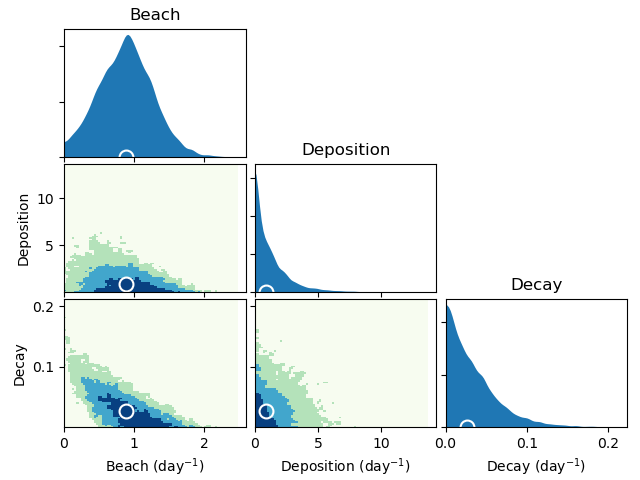

array([0.88913165, 0.88584878, 0.02668093])

In [400]:
log_prob_samples = sampler.get_log_prob(discard=nburn, flat=True)
chain=sampler.get_chain(discard=nburn,flat=True)
# approx_best=chain[np.argmax(log_prob_samples)]
approx_best=np.median(chain,axis=0)

nice_dims={'beach':'Beach','depo':'Deposition','decay':'Decay'}

nd=[nice_dims[d] for d in dims]
u=[units.get(d,'-') for d in dims]

scale=np.array([24,24,1])
u=['day$^{-1}$']*3

# The MAP estimate zeros out deposition and decay, not very
# useful and ignores the huge uncertainty.
# Median is maybe more useful, accounting for the range of
# each parameter. 
fig,axs=pairplot(chain*scale[None,:],nd,
                 #map_est=map_est*scale,
                 map_est=scale*approx_best,
                 log_prob=log_prob_samples,ci=0.8,
                 units=u)
fig.savefig('beach_depo_decay_corner.png',dpi=150)
scale*approx_best

In [385]:
# Interesting that beaching and deposition are so similar here.
# But they have quite different shapes, so not a danger that they're
# duplicated in the model.
approx_best

array([0.03704715, 0.03691037, 0.02668093])

In [376]:
# Bottom line, fit yields MAP estimate
# array([1.41232988e+00, 1.97296105e-02, 5.29584776e-04])
# beaching=1.41 per day
# deposition 0.02 per day
# decay=0.0005 per day

# Why not directly fit MAP estimate:
map_guess=[0.05884708, 0.00082207, 0.00052958]
x0=map_guess
def cb(xk):
    print("Iteration: ",xk)
def cost(theta):
    lp=log_posterior(theta)
    print("log posterior %20f  for theta=%s"%(lp,theta))
    return (-lp).clip(-1000,20000)
result=minimize(cost,x0,bounds=[(0,1),(0,1),(0,1)],
                callback=cb,options=dict(disp=True))
result.x # array([0.06046513, 0.        , 0.        ])

log posterior          -334.034772  for theta=[0.05884708 0.00082207 0.00052958]
log posterior          -334.034772  for theta=[0.05884709 0.00082207 0.00052958]
log posterior          -334.034773  for theta=[0.05884708 0.00082208 0.00052958]
log posterior          -334.034772  for theta=[0.05884708 0.00082207 0.00052959]
log posterior          -590.688056  for theta=[1. 0. 0.]
log posterior          -590.688053  for theta=[0.99999999 0.         0.        ]
log posterior          -590.688099  for theta=[1.e+00 1.e-08 0.e+00]
log posterior          -590.688070  for theta=[1.e+00 0.e+00 1.e-08]
log posterior          -334.042418  for theta=[0.06093647 0.00082024 0.0005284 ]
log posterior          -334.042418  for theta=[0.06093648 0.00082024 0.0005284 ]
log posterior          -334.042419  for theta=[0.06093647 0.00082025 0.0005284 ]
log posterior          -334.042418  for theta=[0.06093647 0.00082024 0.00052841]
log posterior          -334.034345  for theta=[0.05923485 0.00082173 0.00052

array([0.06046513, 0.        , 0.        ])

In [379]:
# for comparison between v01 and v02
df_test=predict_mantas_fast(decay_rate=0.0,beach_rate=0.05,depo_rate=0.0)
df_test.head()

INFO:utils:13
INFO:utils:35


,idx,storm_factor,decay_rate,step,Msmooth_i,beach_rate,depo_rate,C_model,SampleID,SAMPLE LOCATION,...,part_per_m3_std,part_per_m2_std,part_per_m3_raw_std,part_per_m2_raw_std,part_per_m3_nofiber,part_per_m2_nofiber,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y
0,0,0.326,0.0,-10000,0,0.05,0.0,0.017899,CB-4-Manta-21Aug2017,CB4,...,0.224191,0.021298,0.442172,0.042006,0.015526,0.001475,0.024841,0.002360,550040.331073,4.198063e+06
1,1,0.326,0.0,-10000,0,0.05,0.0,0.010077,SPB3-Manta-21Aug2017,SPB3,...,1.817781,0.172689,1.928407,0.183199,0.296678,0.028184,0.301706,0.028662,557329.971756,4.209634e+06
2,2,0.326,0.0,-10000,0,0.05,0.0,0.011864,SUB1-Manta-21Aug2017,SUB1,...,NaN,NaN,0.000000,0.000000,0.032671,0.003104,0.039205,0.003724,582363.556136,4.217527e+06
3,3,0.326,0.0,-10000,0,0.05,0.0,0.007506,SPB2-Manta-21Aug2017,SPB2,...,0.210549,0.020002,0.402882,0.038274,0.021966,0.002087,0.034288,0.003257,550464.046320,4.210092e+06
4,4,0.326,0.0,-10000,0,0.05,0.0,0.016433,CB9-Manta-22Aug2017,CB9,...,0.085947,0.008165,0.174186,0.016548,0.085947,0.008165,0.091677,0.008709,562183.425087,4.171973e+06


In [378]:
# Keeping scale at 1 forces deposition to 0.0.
# Allowing scale to go whereever *still* has deposition 
# and decay at 1.0.

map_guess=[0.05884708, 0.00082207, 0.00052958, 1.0]
x0=map_guess
def cb(xk):
    print("Iteration: ",xk)
def cost(theta):
    theta,scale=theta[:-1],theta[-1]
    lp=log_posterior(theta,scale=scale)
    print("log posterior %20f  for theta=%s"%(lp,theta))
    return (-lp).clip(-1000,20000)
result=minimize(cost,x0,bounds=[(0,1),(0,1),(0,1),(0,20)],
                callback=cb,options=dict(disp=True))
result.x # ([0.34524287, 0.        , 0.        , 4.50519861])

log posterior          -334.034772  for theta=[0.05884708 0.00082207 0.00052958]
log posterior          -334.034772  for theta=[0.05884709 0.00082207 0.00052958]
log posterior          -334.034773  for theta=[0.05884708 0.00082208 0.00052958]
log posterior          -334.034772  for theta=[0.05884708 0.00082207 0.00052959]
log posterior          -334.034772  for theta=[0.05884708 0.00082207 0.00052958]
log posterior          -377.459976  for theta=[1. 0. 0.]
log posterior          -377.459975  for theta=[0.99999999 0.         0.        ]
log posterior          -377.459990  for theta=[1.e+00 1.e-08 0.e+00]
log posterior          -377.459981  for theta=[1.e+00 0.e+00 1.e-08]
log posterior          -377.459976  for theta=[1. 0. 0.]
log posterior          -335.055206  for theta=[0.09056957 0.00079436 0.00051173]
log posterior          -335.055207  for theta=[0.09056958 0.00079436 0.00051173]
log posterior          -335.055208  for theta=[0.09056957 0.00079437 0.00051173]
log posterior      

log posterior          -331.904846  for theta=[0.38430646 0.         0.        ]
log posterior          -331.904846  for theta=[0.38430647 0.         0.        ]
log posterior          -331.904848  for theta=[3.84306457e-01 1.00000000e-08 0.00000000e+00]
log posterior          -331.904846  for theta=[3.84306457e-01 0.00000000e+00 1.00000000e-08]
log posterior          -331.904846  for theta=[0.38430646 0.         0.        ]
Iteration:  [0.38430646 0.         0.         4.97330707]
log posterior          -331.898560  for theta=[0.36380576 0.         0.        ]
log posterior          -331.898560  for theta=[0.36380577 0.         0.        ]
log posterior          -331.898562  for theta=[3.63805755e-01 1.00000000e-08 0.00000000e+00]
log posterior          -331.898560  for theta=[3.63805755e-01 0.00000000e+00 1.00000000e-08]
log posterior          -331.898560  for theta=[0.36380576 0.         0.        ]
Iteration:  [0.36380576 0.         0.         4.75864699]
log posterior          -33

array([0.34524287, 0.        , 0.        , 4.50519861])

In [ ]:
nwalkers = 8  # number of MCMC walkers
nburn = 4000  # "burn-in" period to let chains stabilize
nsteps = 8000  # number of MCMC steps to take


starting_guesses = np.random.rand(nwalkers, ndim)
# we'll start at random locations between 0 and 0.5
starting_guesses[:,0] *= 0.5 # beach rate [0,0.5]
starting_guesses[:,1] *= 0.1 # depo rate [0,0.1]
starting_guesses[:,2] *= 0.1 # decay rate [0,0.1]

back=emcee.backends.HDFBackend("samples-emcee-v01-nbinom_scale_v1.h5")

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=[],
                               backend=back)

sampler.run_mcmc(starting_guesses, nsteps,progress=True)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :]  # discard burn-in points

In [ ]:
# sampler.chain.shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :]  # discard burn-in points
fig,axs=plt.subplots(1,ndim,figsize=(8,4))
for i,(ax,dim) in enumerate(zip(axs,dims)):
    ax.hist(sample[:,:,i].ravel(),
            bins=100)
    ax.text(0.01,0.99,dim,transform=ax.transAxes,va='top')

In [ ]:
fig,axs=plt.subplots(ndim,1,figsize=(9,6))
for i,(ax,dim) in enumerate(zip(axs,dims)):
    ax.plot( sampler.chain[:,:,i].T,lw=0.4)
    ax.text(0.01,0.99,dim,transform=ax.transAxes,va='top')

In [ ]:
# Seems to be pretty slow to get burn in, still hasn't really gotten
# to a good neighborhood.
# Get a max a posteriori estimate, which might be a better starting point
# for the sampling.
# This yields [0.229,0,0]
# How sensitive is that alpha? Hand-tuning shows that using the output of
# this optimization, then adjust alpha, alpha=1.8+-0.2
x0=[0.1,0.01,0.01]
def cb(xk):
    print("Iteration: ",xk)    
def cost(theta):
    lp=log_posterior(theta)
    print("log posterior %20f  for theta=%s"%(lp,theta))
    return (-lp).clip(-1000,20000)
result=minimize(cost,x0,bounds=[(0,1),(0,1),(0,1)],
                callback=cb,options=dict(disp=True))
result.x

In [ ]:
theta=[0.229,0,0]
# Not bad -- suggests alpha~1.80
for alpha in [1,1.2,1.4,1.6,1.8,2,2.2,2.5,2.8,2.9,3.0,3.1,3.2,3.3,3.4]:
    # Knowing that alpha was fit across samples that had a lot of modeled
    # variance in addition to unmodeled variance, explore smaller alpha
    lp=log_posterior(theta,alpha=alpha)
    print(f"alpha={alpha:5.2f}  lp={lp:.6f}")

In [ ]:
# Start with the result of that optimization, but now also tune alpha.
x0=[0.1,0.01,0.01,1.8]
def cb(xk):
    print("Iteration: ",xk)
def cost(theta):
    theta,alpha=theta[:-1],theta[-1]
    lp=log_posterior(theta,alpha=alpha)
    print("log posterior %20f  for theta=%s alpha=%.4f"%(lp,theta,alpha))
    return (-lp).clip(-1000,20000)
result=minimize(cost,x0,bounds=[(0,1),(0,1),(0,1),(1,3.4)],
                callback=cb,options=dict(disp=True))
result.x # [0.22875575, 0.        , 0.        , 1.75525524]

In [ ]:
# Get the actual predictions for those two parameter sets:
dfA=predict_mantas_fast(decay_rate=0.0,
                        beach_rate=0.10445219,
                        depo_rate=0.0)
dfA['C_model']*=0.5 # scale

dfB=predict_mantas_fast(decay_rate=0.0,
                        beach_rate=0.49704642,
                        depo_rate=0.0)
dfB['C_model']*=2.10064182 # scale

In [ ]:
# Start with scatter, area concentration units
fig,axs=plt.subplots(1,2,sharex=True,sharey=True)


axs[0].scatter(dfA['part_per_m2_nofiber'],dfA['C_model'],30,
               dfA['area_m2'])
axs[1].scatter(dfB['part_per_m2_nofiber'],dfB['C_model'],30,
               dfB['area_m2'])

In [ ]:
fig=plt.figure(figsize=(9.25,7.5))
ax=fig.add_axes([0,0,1,1])

grid.plot_cells(values=grid.cells['cell_depth'],cmap='gray',clim=[0,100])

kws=dict(cmap='turbo',clim=[-3,1])
sel=dfA['Season']=='Dry'
scat=ax.scatter(dfA['x'],
                dfA['y'],
                20+60*sel,
                np.log10(dfA['C_model']/dfB['C_model']),**kws)
ax.text(0.03,0.99,"Greater => scale=0.5 result is larger.\nLarge dots are Dry",transform=ax.transAxes,va='top')
cax=fig.add_axes([0.03,0.5,0.02,0.25])
plt.colorbar(scat,cax=cax)

ax.axis('equal')

# so the coastal ocean ones are a mix, and maybe there is an issue with seasons?
# Dry season values are smaller in the scale=0.5 case.
# Wet season predictions are greater when scale=0.5, low beaching.
# So beaching is more relevant for coast samples in the wet season.
# maybe storm water samples are more prone to beaching, and are more
# relevant in the wet season.


# Some LSB samples are much greater when scale is small, because that forces beaching
# to be small and they probably are getting beached a lot down there.
# The rest of south bay is a wash.
# Central Bay has some samples that are much smaller when scale is 0.5, since
# these have relatively low beaching,being far from shore and in deep water.

# so what we're seeing is basically a seasonal pattern (beaching preferentially
# reduces wet season concentration), and a spatial pattern (beaching preferentially
# reduces LSB and maybe Suisun, and Central Bay is unaffected by beaching)



In [398]:
from scipy.stats import spearmanr
def skill_summary(df):
    obs=df['part_per_m2_nofiber']
    # ensure that observed values are positive.
    detect_limit=0.5*obs[obs>0].min()
    obs=obs.clip(detect_limit)
    mod=df['C_model']
    
    print(f"Bias: {np.mean(mod-obs):.4f}")
    print(f"Geometric mean error: {np.exp(np.mean(np.log(mod/obs))):.3f}")
    Rlin=np.corrcoef(mod,obs)[1,0]
    print(f"Linear Pearson R: {Rlin:.3f}")
    Rlog=np.corrcoef(np.log(mod),np.log(obs))[0,1]
    print(f"Log Pearson R: {Rlog:.3f}  R2: {Rlog**2:.3f}")
    # spearman
    rho,rho_p=spearmanr(mod,obs)
    print(f"Spearman rho: {rho:.3f}")
    print()


# Skill, absent any parameter tweaking:
df=predict_mantas_fast(decay_rate=0,beach_rate=0,depo_rate=0)
print("No calibration:")
skill_summary(df)

# MAP without scaling
df1=predict_mantas_fast(decay_rate=0,beach_rate=0.06046516,depo_rate=0)
print("MAP parameters, no scaling:")
skill_summary(df1)

# median parameters
df2=predict_mantas_fast(decay_rate=0.02668093,beach_rate=0.03704715,depo_rate=0.03691037)
print("median parameters:")
skill_summary(df2)


No calibration:
Bias: 0.3196
Geometric mean error: 12.780
Linear Pearson R: 0.078
Log Pearson R: 0.677  R2: 0.459
Spearman rho: 0.708

MAP parameters, no scaling:
Bias: 0.0034
Geometric mean error: 2.246
Linear Pearson R: 0.189
Log Pearson R: 0.689  R2: 0.475
Spearman rho: 0.720

median parameters:
Bias: 0.0235
Geometric mean error: 2.297
Linear Pearson R: 0.129
Log Pearson R: 0.685  R2: 0.470
Spearman rho: 0.718



In [ ]:
from 

In [388]:
df.columns

Index(['idx', 'storm_factor', 'decay_rate', 'step', 'Msmooth_i', 'beach_rate',
       'depo_rate', 'C_model', 'SampleID', 'SAMPLE LOCATION', 'DATE', 'TYPE',
       'LAT START', 'LONG START', 'LAT END', 'LONG END', 'TOTAL DIST (M)',
       'START FLOW', 'END FLOW', 'area_km2', 'volume_m3', 'FibersYN', 'Season',
       'time_local', 'time_utc', 'lat', 'lon', 'volume_l', 'area_m2',
       'count_preblank_std', 'count_preblank_nofiber', 'Fiber', 'Fiber Bundle',
       'Film', 'Foam', 'Fragment', 'Sphere', 'Fiber_adj', 'Fiber Bundle_adj',
       'Fragment_adj', 'Foam_adj', 'Film_adj', 'Sphere_adj', 'count_std',
       'count_nofiber', 'part_per_m3_std', 'part_per_m2_std',
       'part_per_m3_raw_std', 'part_per_m2_raw_std', 'part_per_m3_nofiber',
       'part_per_m2_nofiber', 'part_per_m3_raw_nofiber',
       'part_per_m2_raw_nofiber', 'x', 'y'],
      dtype='object')

Predicted Distributions
---

Predicted distribution of beached and deposited particles.
